## Density based anomaly detection

### 1. Ready to analysis

#### 1) Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter

from sklearn.datasets import make_blobs
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

#### 2) Setting toy dataset with some novelty

In [2]:
# setting dataset size and parameter

n_samples = 1000
outliers_fraction = 0.05
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
blobs_params = dict(random_state=333, n_samples=n_inliers, n_features=2)
abnormal = 25.0 * (np.random.RandomState(333).rand(n_outliers, 2))

In [3]:
datasets = []

d1 = [x for x in make_blobs(centers=[[5, 10], [5, 10]], cluster_std=1.2, **blobs_params)[0]]
[d1.append(x) for x in abnormal]
d1=np.array(d1)

d2 = [x for x in make_blobs(centers=[[5, 10], [10, 20]], cluster_std=[1.5, 1.5], **blobs_params)[0]]
[d2.append(x) for x in abnormal]
d2=np.array(d2)

d3 = [x for x in make_blobs(centers=[[5, 10], [10, 20]], cluster_std=[1.5, 2.8], **blobs_params)[0]]
[d3.append(x) for x in abnormal]
d3=np.array(d3)

datasets.append(d1)
datasets.append(d2)
datasets.append(d3)

datasets

[array([[ 2.70839387, 10.32977613],
        [ 3.91522112,  7.68471831],
        [ 5.48620102, 10.84600053],
        ...,
        [11.52704556, 11.99700008],
        [ 3.51115863, 19.15479856],
        [22.08158806, 21.3710665 ]]),
 array([[ 2.13549234, 10.41222017],
        [ 3.6440264 ,  7.10589788],
        [10.60775127, 21.05750067],
        ...,
        [11.52704556, 11.99700008],
        [ 3.51115863, 19.15479856],
        [22.08158806, 21.3710665 ]]),
 array([[ 2.13549234, 10.41222017],
        [ 3.6440264 ,  7.10589788],
        [11.13446904, 21.97400124],
        ...,
        [11.52704556, 11.99700008],
        [ 3.51115863, 19.15479856],
        [22.08158806, 21.3710665 ]])]

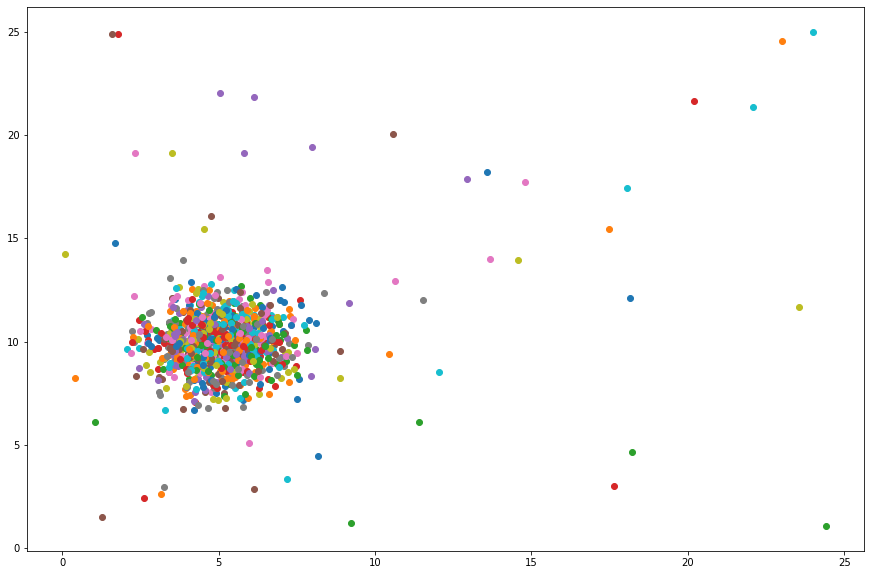

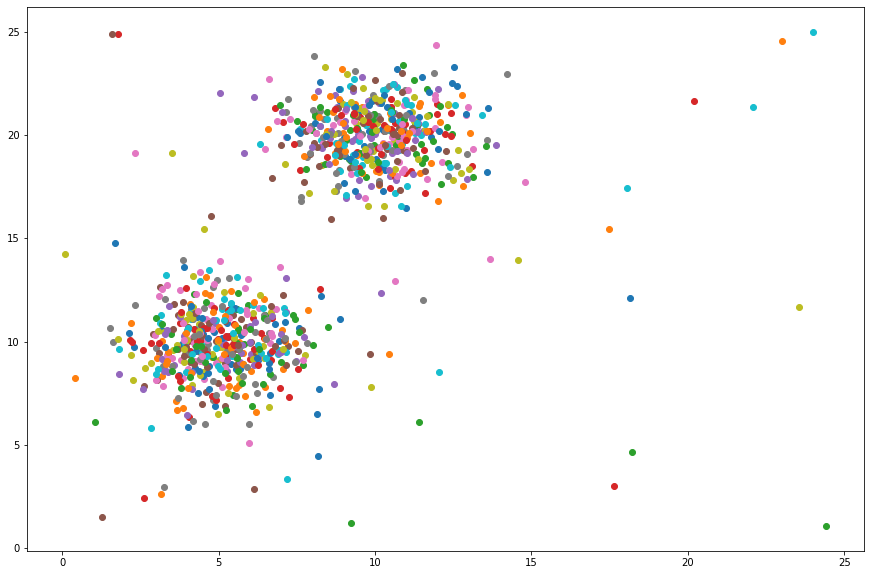

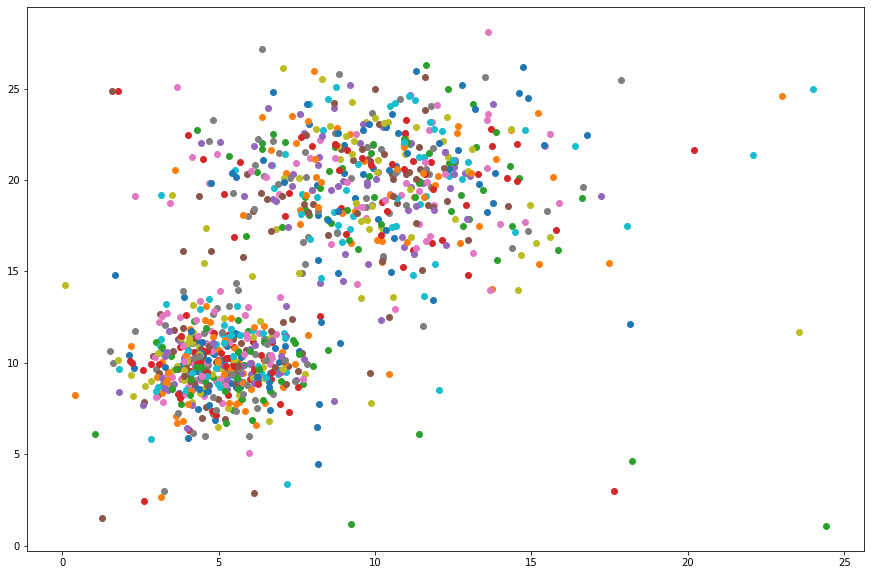

In [4]:
for idx, form in enumerate(datasets):
    plt.figure(figsize=(15, 10))
    for i in form:
        plt.scatter(i[0], i[1])
    plt.savefig(f'C:/Users/kw764/Desktop/kw/00_lecture/2022-2/BA/튜토리얼이미지/dataset_{idx}.png', edgecolor='black', format='png', dpi=200)

In [5]:
print(datasets[0].shape)
print(datasets[1].shape)
print(datasets[2].shape)

(1000, 2)
(1000, 2)
(1000, 2)


### 2. Methods

#### 1) Parametric Method : Using Gaussian distribution

#####   - setting estimators

In [6]:
# Estimate Gaussian parameters 

def gaussian_estimator(dataset):
    
    avg1 = np.mean(dataset.T[0])
    avg2 = np.mean(dataset.T[1])
    avg = np.array([avg1, avg2])
    stdev = np.std(dataset, axis=0)
    print(avg, stdev)
    
    return avg, stdev

In [7]:
# Estimate Gaussian distribution

def multi_gaussian_estimator(dataset, avg, stdev):
    
    k = len(avg)
    stdev=np.diag(stdev)
    dataset = dataset - avg.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(stdev)**0.5))* np.exp(-0.5* np.sum(dataset @ np.linalg.pinv(stdev) * dataset ,axis=1))
    
    return p

#####   - Using gaussian density estimation(single distribution)

[ 5.25476149 10.10065257] [2.17972281 2.07653618]
[ 7.63626645 14.84283774] [3.24595173 5.41880706]
[ 7.64464415 14.85319246] [3.61267098 5.65677678]


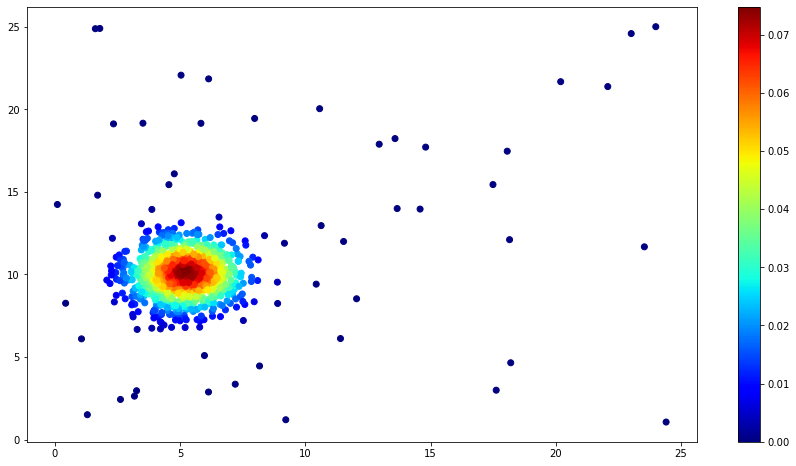

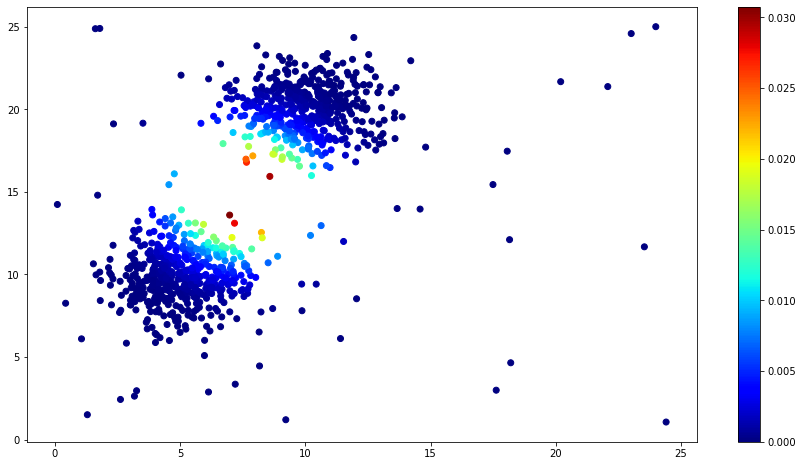

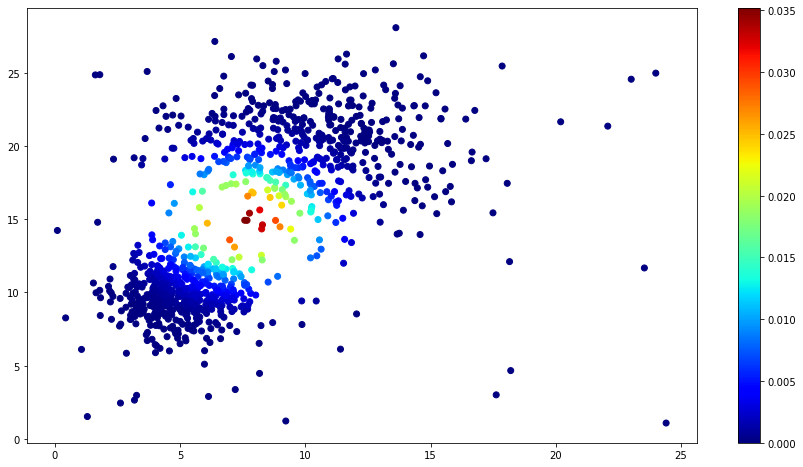

In [8]:
# plotting gaussian density(single distribution)

avg_list = []
std_list = []
dist_list = []

for idx, dataset in enumerate(datasets):
    avg, stdev = gaussian_estimator(dataset)
    avg_list.append(avg)
    std_list.append(stdev)
    p = multi_gaussian_estimator(dataset, avg, stdev)
    dist_list.append(p)
    
    plt.figure(figsize=(15,8))
    plt.scatter(dataset[:,0], dataset[:,1], marker = "o", c=p, cmap='jet');
    plt.colorbar();

    plt.savefig(f'C:/Users/kw764/Desktop/kw/00_lecture/2022-2/BA/튜토리얼이미지/single_gaussian_{idx}.png', edgecolor='black', format='png', dpi=200)

number of outlier : 45
number of outlier : 501
number of outlier : 524


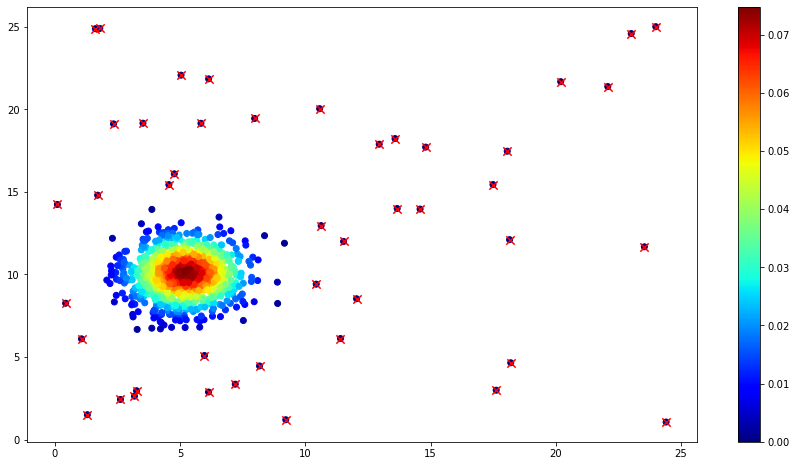

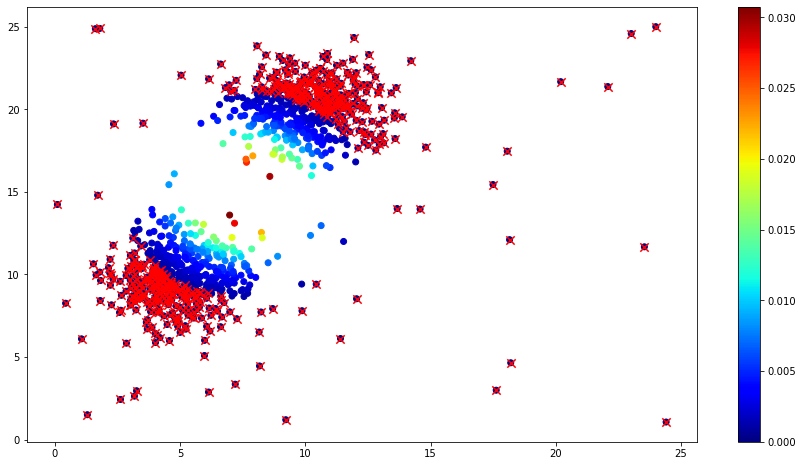

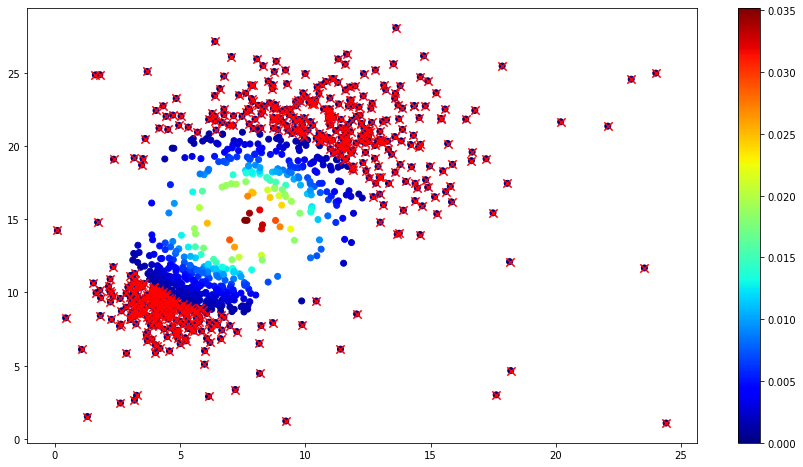

In [9]:
# detecting & plot novelties

epsilon = 0.001 # setting threshold

i = 0
for p, dataset in zip(dist_list, datasets):
    
    novelty = np.nonzero(p<epsilon)[0]
    
    print("number of outlier : " + str (len(novelty)))
    
    plt.figure(figsize=(15,8))
    plt.scatter(dataset[:,0], dataset[:,1], marker = "o", c=p, cmap='jet');
    plt.colorbar();
    plt.scatter(dataset[novelty,0],dataset[novelty,1],marker="x",c='r' ,s=70); # plot novelties

    plt.savefig(f'C:/Users/kw764/Desktop/kw/00_lecture/2022-2/BA/튜토리얼이미지/single_gaussian_{i}_outlier_plot.png', edgecolor='black', format='png', dpi=200)
    i += 1

#####    - Using mixture of gaussian(MoG)

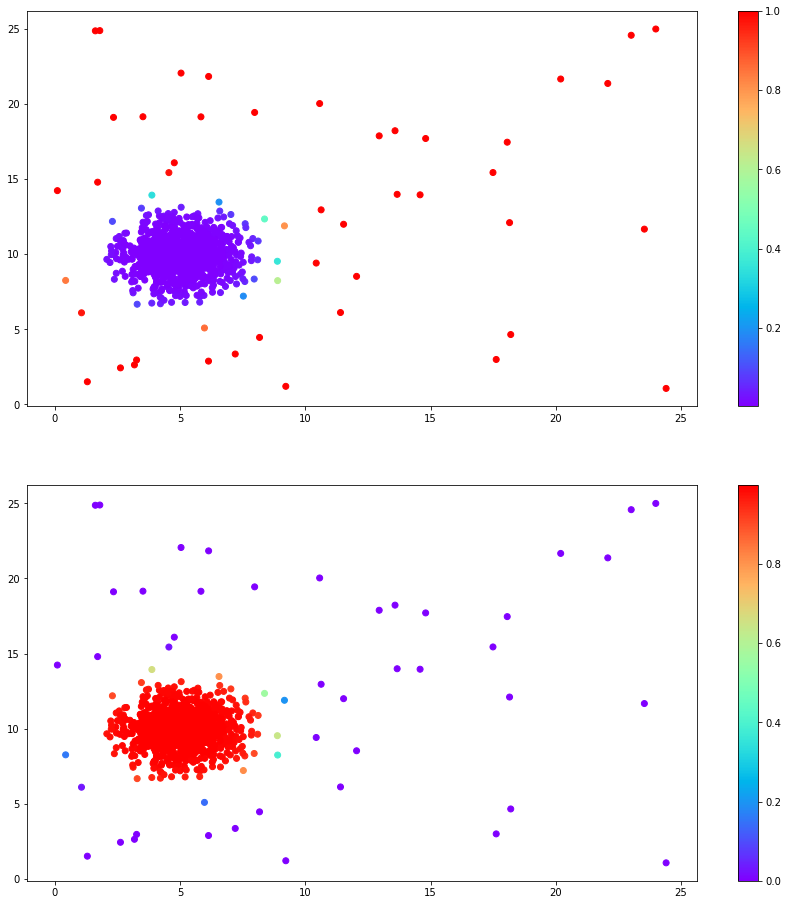

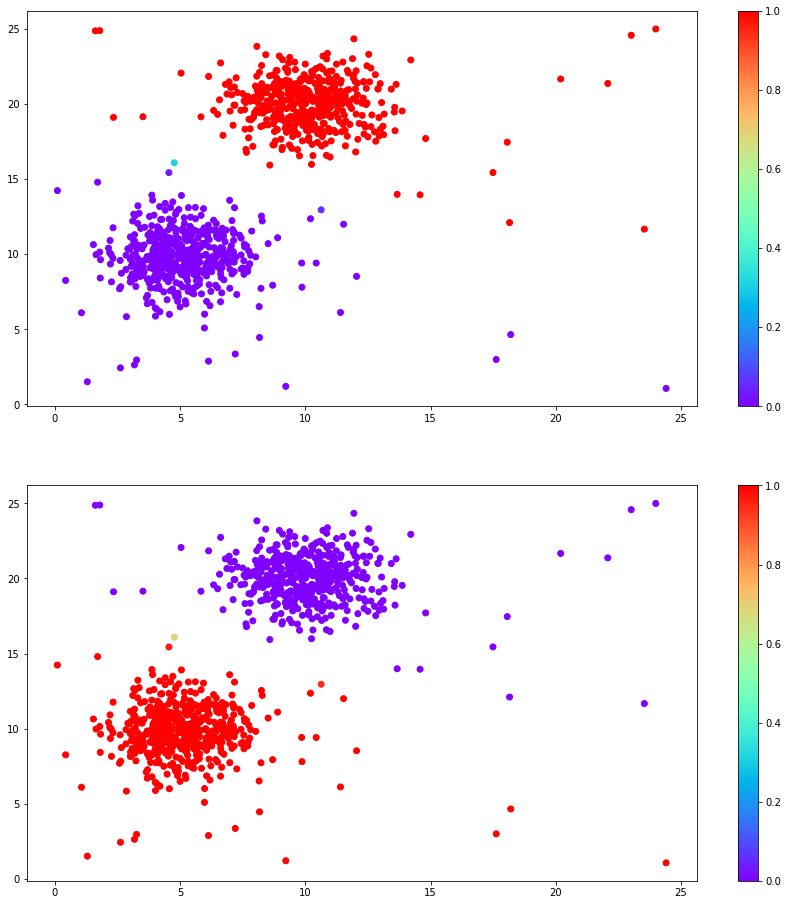

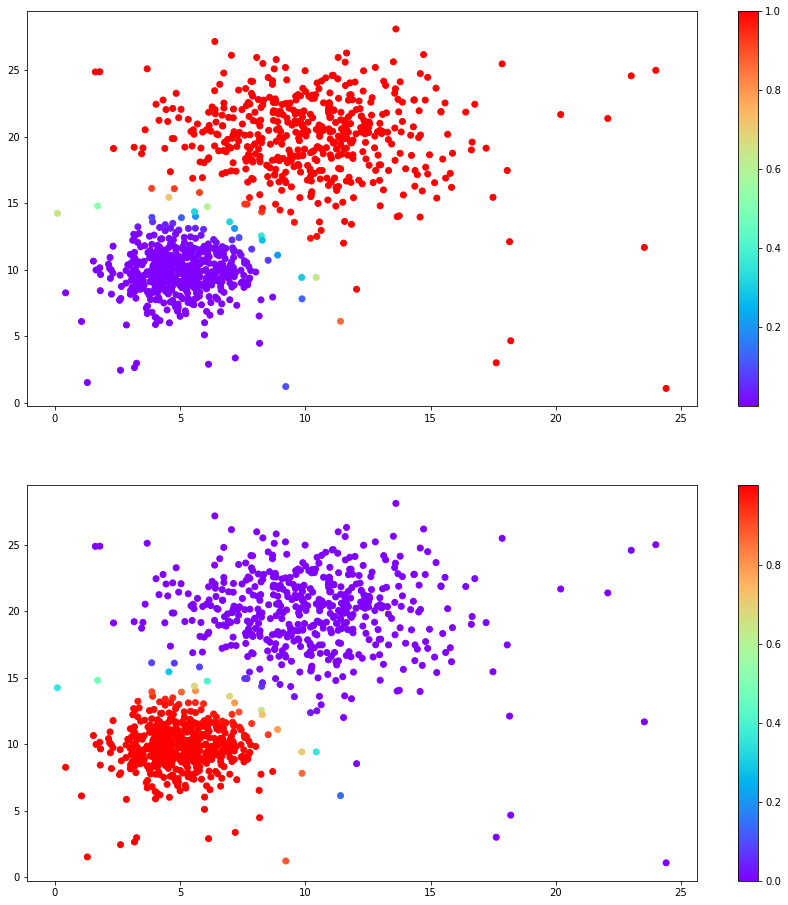

In [10]:
idx = 0
for p, dataset in zip(dist_list, datasets):
    mog = GaussianMixture(n_components = 2, covariance_type = 'full', random_state=333)
    mog.fit(dataset)
    
    plt.figure(figsize=(15,16))
    for i in range(2):
        plt.subplot(2, 1, i+1)
        plt.scatter(dataset[:,0],dataset[:,1],c=mog.predict_proba(dataset)[:,i],cmap='rainbow',marker='o')
        plt.colorbar();
        
    plt.savefig(f'C:/Users/kw764/Desktop/kw/00_lecture/2022-2/BA/튜토리얼이미지/MoG_{idx}.png', edgecolor='black', format='png', dpi=200)
    
    idx += 1

#### 2) Non-parametric method : Local Outlier Factor

Counter({1: 955, -1: 45})
number of outlier : 45
Counter({1: 955, -1: 45})
number of outlier : 45
Counter({1: 955, -1: 45})
number of outlier : 45


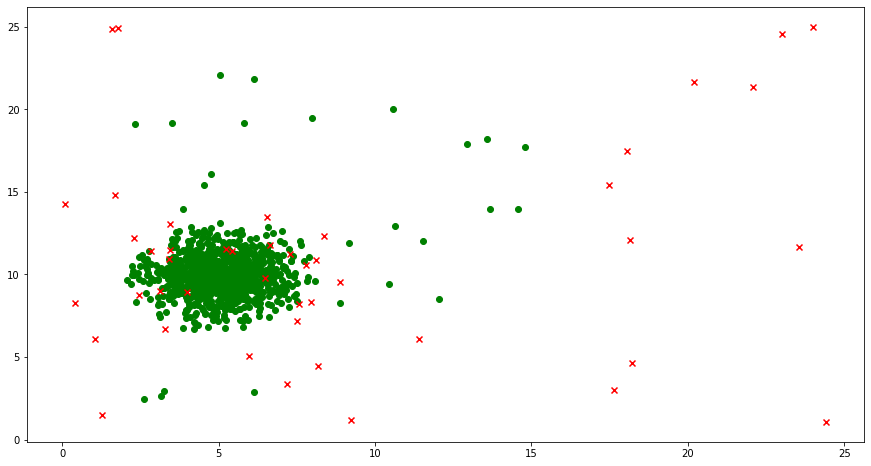

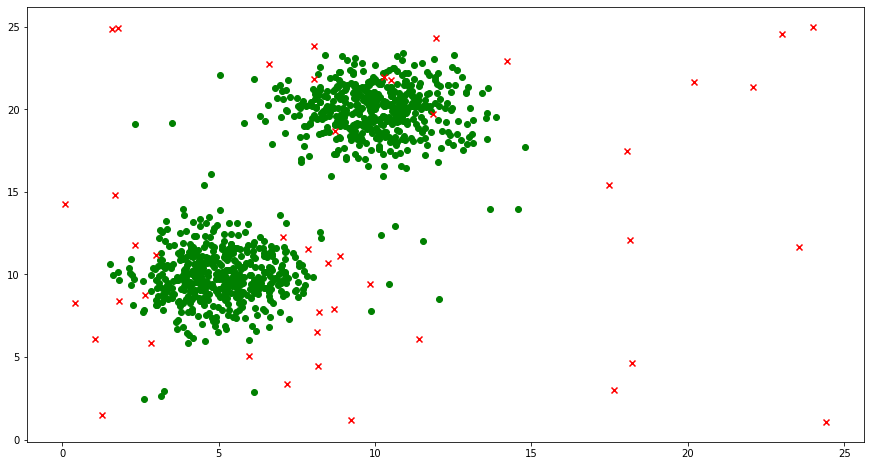

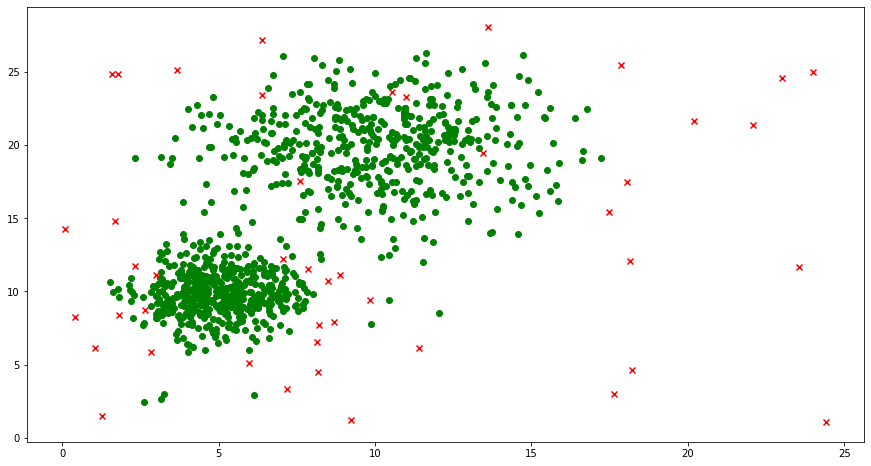

In [11]:
lof = LocalOutlierFactor(n_neighbors=5)
result_lof = lof.fit_predict(dataset)

i = 0
for dataset in datasets:
    print(Counter(result_lof))
    df_lof = {'X1':dataset.T[0], 'X2':dataset.T[1], 'result_lof':result_lof, 'outlier_factor':lof.negative_outlier_factor_}
    df_lof = pd.DataFrame(df_lof)
    
    df_normal = df_lof[df_lof['result_lof'] == 1]
    df_abnormal = df_lof[df_lof['result_lof'] == -1]
    
    print("number of outlier : " + str (len(df_abnormal)))
    
    plt.figure(figsize=(15,8))
    plt.scatter(df_normal['X1'], df_normal['X2'], marker = "o", c='g')
    plt.scatter(df_abnormal['X1'],df_abnormal['X2'],marker="x", c='r') # plot novelties

    plt.savefig(f'C:/Users/kw764/Desktop/kw/00_lecture/2022-2/BA/튜토리얼이미지/LOF_{i}.png', edgecolor='black', format='png', dpi=200)
    i += 1